# Color models


## 1. Install and Import Required Libraries

We will use PyTorch, torchvision, numpy, matplotlib, and tqdm. If running locally, ensure these packages are installed.

In [1]:
# Install required packages (uncomment if running in a new environment)
# !pip install torch torchvision matplotlib tqdm numpy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
max_training_time = 60*5
display_interval = 30
print(device)

cuda


## 2. Load and Preprocess Dataset

We will use any image directory for demonstration. The images will be normalized to [-1, 1] as required by most diffusion models.

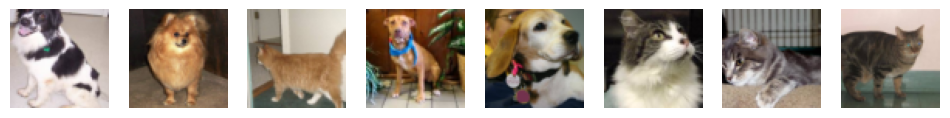

8000


In [ ]:


# Scale to [-1, 1] (diffusion models usually expect this)
def scale_to_minus_one_to_one(x):
    return x * 2. - 1.


class CenterCropSquare:
    def __call__(self, img: Image.Image):
        w, h = img.size
        min_side = min(w, h)
        left = (w - min_side) // 2
        top = (h - min_side) // 2
        right = left + min_side
        bottom = top + min_side
        return img.crop((left, top, right, bottom))

transform = transforms.Compose([
    CenterCropSquare(),                        # crop to centered square
    transforms.Resize((64, 64)),               # resize to 64x64
    transforms.ToTensor(),
    transforms.Lambda(scale_to_minus_one_to_one),
])


# # Preprocessing pipeline
# transform = transforms.Compose([
#     transforms.Resize((64, 64)),      # Resize all images to 64x64
#     transforms.ToTensor(),            # Convert to tensor in [0,1]
#     transforms.Lambda(scale_to_minus_one_to_one)  # Scale to [-1,1]
# ])

# Point this to the root folder that contains subfolders like "cat/", "dog/"
data_root = "./data/images"
data_root = "/home/ron/proj/pics/backup_plus_thuy_pics"
# https://www.kaggle.com/datasets/chetankv/dogs-cats-images
data_root = "./data/cats_and_dogs/dataset/training_set"
batch_size = 128
train_dataset = datasets.ImageFolder(root=data_root, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Visualize a batch
examples, _ = next(iter(train_loader))  # grab a batch
examples = examples[:8]  # just first 8

fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i, img in enumerate(examples):
    # Unscale back to [0,1] for display
    img_disp = (img * 0.5 + 0.5).permute(1, 2, 0).numpy()
    axes[i].imshow(img_disp)
    axes[i].axis("off")
plt.show()
print(len(train_dataset))

## 3. Define the Diffusion Model Architecture

We will use a simple U-Net-like architecture suitable for MNIST. For more complex datasets, a deeper U-Net or transformer-based model may be used.

In [4]:
# Standard U-Net with skip connections and timestep embedding for 28x28 images (fixed output channels)
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = np.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb

    
class UNet64(nn.Module):
    """
    sucked
    """
    def __init__(self, emb_dim=128):
        super().__init__()
        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(emb_dim),
            nn.Linear(emb_dim, emb_dim),
            nn.ReLU(),
        )

        # Encoder
        self.inc = nn.Conv2d(3, 64, 3, padding=1)              # 64x64 -> 64x64
        self.down1 = nn.Conv2d(64, 128, 4, stride=2, padding=1)  # 64x64 -> 32x32
        self.down2 = nn.Conv2d(128, 256, 4, stride=2, padding=1) # 32x32 -> 16x16
        self.down3 = nn.Conv2d(256, 512, 4, stride=2, padding=1) # 16x16 -> 8x8

        # Time embeddings for skips
        self.emb1 = nn.Linear(emb_dim, 128)
        self.emb2 = nn.Linear(emb_dim, 256)
        self.emb3 = nn.Linear(emb_dim, 512)

        # Bottleneck
        self.middle = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(),
        )

        # Decoder
        self.up3 = nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1) # 8x8 -> 16x16
        self.up2 = nn.ConvTranspose2d(512, 128, 4, stride=2, padding=1) # 16x16 -> 32x32
        self.up1 = nn.ConvTranspose2d(256, 64, 4, stride=2, padding=1)  # 32x32 -> 64x64

        self.emb_up3 = nn.Linear(emb_dim, 256)
        self.emb_up2 = nn.Linear(emb_dim, 128)
        self.emb_up1 = nn.Linear(emb_dim, 64)

        self.outc = nn.Conv2d(128, 3, 1)  # 64 + 64 = 128 after concat

    def forward(self, x, t):
        # Time embedding
        if t.dim() == 1:
            t = t.float()
        else:
            t = t.squeeze(-1).float()
        emb = self.time_mlp(t)

        # Encoder
        x1 = F.relu(self.inc(x))  # (B,64,64,64)
        x2 = F.relu(self.down1(x1) + self.emb1(emb)[:, :, None, None])
        x3 = F.relu(self.down2(x2) + self.emb2(emb)[:, :, None, None])
        x4 = F.relu(self.down3(x3) + self.emb3(emb)[:, :, None, None])

        # Middle
        m = self.middle(x4)

        # Decoder
        u3 = F.relu(self.up3(m) + self.emb_up3(emb)[:, :, None, None])
        u3 = torch.cat([u3, x3], dim=1)

        u2 = F.relu(self.up2(u3) + self.emb_up2(emb)[:, :, None, None])
        u2 = torch.cat([u2, x2], dim=1)

        u1 = F.relu(self.up1(u2) + self.emb_up1(emb)[:, :, None, None])
        u1 = torch.cat([u1, x1], dim=1)

        out = self.outc(u1)
        return out







In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# -----------------------------
# Positional embedding for timestep/sigma
# -----------------------------
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb


# -----------------------------
# Simple self-attention block
# -----------------------------
class SelfAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)
        q, k, v = self.qkv(h).chunk(3, dim=1)
        q = q.reshape(B, C, H*W).permute(0, 2, 1)  # B, HW, C
        k = k.reshape(B, C, H*W)                    # B, C, HW
        attn = torch.bmm(q, k) / (C ** 0.5)
        attn = F.softmax(attn, dim=-1)
        v = v.reshape(B, C, H*W).permute(0, 2, 1)
        h = torch.bmm(attn, v).permute(0, 2, 1).reshape(B, C, H, W)
        return x + self.proj(h)


# -----------------------------
# Residual block with optional attention
# -----------------------------
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, emb_dim, use_attention=False):
        super().__init__()
        self.use_attention = use_attention
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time_mlp = nn.Linear(emb_dim, out_ch)
        if use_attention:
            self.attn = SelfAttention(out_ch)
        if in_ch != out_ch:
            self.skip = nn.Conv2d(in_ch, out_ch, 1)
        else:
            self.skip = nn.Identity()

    def forward(self, x, t_emb):
        h = F.relu(self.conv1(x))
        h = h + self.time_mlp(t_emb)[:, :, None, None]
        h = F.relu(self.conv2(h))
        if self.use_attention:
            h = self.attn(h)
        return h + self.skip(x)


# -----------------------------
# 64x64 RGB U-Net (channel-corrected)
# -----------------------------
class UNet128(nn.Module):
    def __init__(self, in_channels=3, base_ch=64, emb_dim=128, use_attention=True):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(emb_dim),
            nn.Linear(emb_dim, emb_dim),
            nn.ReLU()
        )

        # Down path
        self.inc = ResBlock(in_channels, base_ch, emb_dim)
        self.down1 = ResBlock(base_ch, base_ch*2, emb_dim)
        self.down2 = ResBlock(base_ch*2, base_ch*4, emb_dim, use_attention=use_attention)
        self.down3 = ResBlock(base_ch*4, base_ch*4, emb_dim, use_attention=use_attention)
        self.pool = nn.AvgPool2d(2)

        # Middle
        self.mid = ResBlock(base_ch*4, base_ch*4, emb_dim, use_attention=use_attention)

        # Up path (channels corrected!)
        self.up3 = nn.ConvTranspose2d(base_ch*4, base_ch*4, 2, stride=2)
        self.up_block3 = ResBlock(base_ch*4 + base_ch*4, base_ch*4, emb_dim, use_attention=use_attention)

        self.up2 = nn.ConvTranspose2d(base_ch*4, base_ch*2, 2, stride=2)
        self.up_block2 = ResBlock(base_ch*2 + base_ch*4, base_ch*2, emb_dim)

        self.up1 = nn.ConvTranspose2d(base_ch*2, base_ch, 2, stride=2)
        self.up_block1 = ResBlock(base_ch + base_ch*2, base_ch, emb_dim)
        
        self.up0 = nn.ConvTranspose2d(base_ch, base_ch, 2, stride=2)
        self.up_block0 = ResBlock(base_ch + base_ch, base_ch, emb_dim)

        # Output
        self.outc = nn.Conv2d(base_ch, in_channels, 1)

    def forward(self, x, t):
        if t.dim() == 1:
            t = t.float()
        else:
            t = t.squeeze(-1).float()
        t_emb = self.time_mlp(t)

        # Downsampling
        x1 = self.inc(x, t_emb)            # 64x64 -> 64x64
        x2 = self.down1(self.pool(x1), t_emb)  # 64->32
        x3 = self.down2(self.pool(x2), t_emb)  # 32->16
        x4 = self.down3(self.pool(x3), t_emb)  # 16->8

        # Middle
        m = self.mid(self.pool(x4), t_emb)     # 8->4
        #print("x shapes",x1.shape, x2.shape)
        # Upsampling
        u3 = self.up_block3(torch.cat([self.up3(m), x4], dim=1), t_emb)  # 4->8
        u2 = self.up_block2(torch.cat([self.up2(u3), x3], dim=1), t_emb) # 8->16
        u1 = self.up_block1(torch.cat([self.up1(u2), x2], dim=1), t_emb) # 16->32
        u0 = self.up_block0(torch.cat([self.up0(u1), x1], dim=1), t_emb) # 16->32

        # Final upsample to original size
        # The Chatbot's "u_final" here results in very noisy images.  Using u0 above is much better.
        #u_final = F.interpolate(u1, size=x.shape[-2:], mode='bilinear', align_corners=False)
        #print("shapes",u3.shape, u2.shape, u1.shape, u0.shape, u_final.shape, "hopefully the last 2 match")
        return self.outc(u0)


In [6]:
model = UNet128(use_attention=True).to(device)
print(model)
#model_edm = UNet128(use_attention=False).to(device)
#model_edm.forward(x,t)

UNet128(
  (time_mlp): Sequential(
    (0): SinusoidalPosEmb()
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): ReLU()
  )
  (inc): ResBlock(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_mlp): Linear(in_features=128, out_features=64, bias=True)
    (skip): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (down1): ResBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_mlp): Linear(in_features=128, out_features=128, bias=True)
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (down2): ResBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_mlp): Linear(in_features=128, out_f

## 4. Implement the Forward Diffusion Process

The forward process gradually adds Gaussian noise to the data over a fixed number of timesteps.

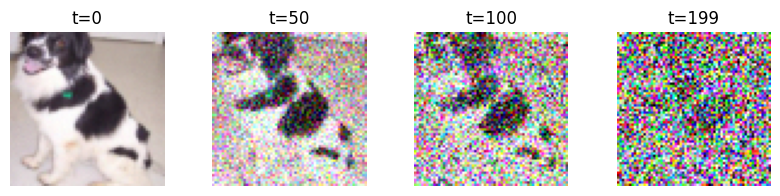

In [7]:
# Forward diffusion process
T = 200  # Number of diffusion steps
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T, device=device)
alphas = 1. - betas
alpha_bars = torch.cumprod(alphas, dim=0)

def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    sqrt_alpha_bar = alpha_bars[t].sqrt().view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar = (1 - alpha_bars[t]).sqrt().view(-1, 1, 1, 1)
    return sqrt_alpha_bar * x_start + sqrt_one_minus_alpha_bar * noise

# Visualize noisy images at different timesteps
x = examples[:4].to(device)  # batch of clean images
timesteps = torch.tensor([0, T//4, T//2, T-1], device=device)

noisy_imgs = [q_sample(x, t.repeat(x.size(0)), noise=None) for t in timesteps]

fig, axes = plt.subplots(1, 4, figsize=(10, 2))
for i, img in enumerate(noisy_imgs):
    img_disp = img[0].detach().cpu()
    img_disp = (img_disp * 0.5 + 0.5).clamp(0, 1)   # unscale [-1,1] → [0,1]
    img_disp = img_disp.permute(1, 2, 0).numpy()   # CHW → HWC
    axes[i].imshow(img_disp)
    axes[i].set_title(f"t={timesteps[i].item()}")
    axes[i].axis('off')
plt.show()


In [8]:
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader

# # Scale to [-1, 1] (diffusion models expect this)
# def scale_to_minus_one_to_one(x):
#     return x * 2. - 1.

# # Transform MNIST to 64x64 RGB (expand single channel to 3)
# transform_mnist = transforms.Compose([
#     transforms.Resize((64, 64)),
#     transforms.ToTensor(),
#     transforms.Lambda(scale_to_minus_one_to_one),
#     transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # make 1-channel -> 3-channel
# ])

# batch_size = 128
# train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# # Quick visualization
# examples, _ = next(iter(train_loader))
# examples = examples[:8]  # first 8 images
# import matplotlib.pyplot as plt
# import torchvision.utils as vutils

# grid = vutils.make_grid((examples * 0.5 + 0.5).clamp(0,1), nrow=8)
# plt.figure(figsize=(12,2))
# plt.imshow(grid.permute(1,2,0).cpu().numpy())
# plt.axis("off")
# plt.show()


## Checkpoint stuff

In [9]:
import torch
import os

import torch
import os
from datetime import datetime

def save_checkpoint(model, optimizer, epoch, loss, path=None, tag = ""):
    checkpoint = {
        "epoch": epoch,
        "loss": loss,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "model_class": model.__class__.__name__,
        "model_repr": str(model),  # optional: full repr for reference
    }

    if path is None:
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        cls_name = model.__class__.__name__
        path = f"checkpoints/{cls_name}_{timestamp}_{tag}.pth"

    dir_name = os.path.dirname(path)
    if dir_name != "":
        os.makedirs(dir_name, exist_ok=True)

    torch.save(checkpoint, path)
    print(f"✅ Saved checkpoint: {path}")

def load_checkpoint(model, optimizer, path, map_location=None):
    checkpoint = torch.load(path, map_location=map_location or "cpu")
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    print(f"🔄 Loaded checkpoint from {path}")
    print(f"    Epoch: {checkpoint.get('epoch', '?')}, Loss: {checkpoint.get('loss', '?')}")
    print(f"    Model class: {checkpoint.get('model_class', '?')}")
    return model, optimizer, checkpoint




## 6. Elucidated Diffusion Model (EDM) Implementation

This section implements the EDM as described in the paper (2206.00364v2.pdf), including its unique noise schedule, loss weighting, and sampling procedure.

### 6a. EDM loss and schedule functions.

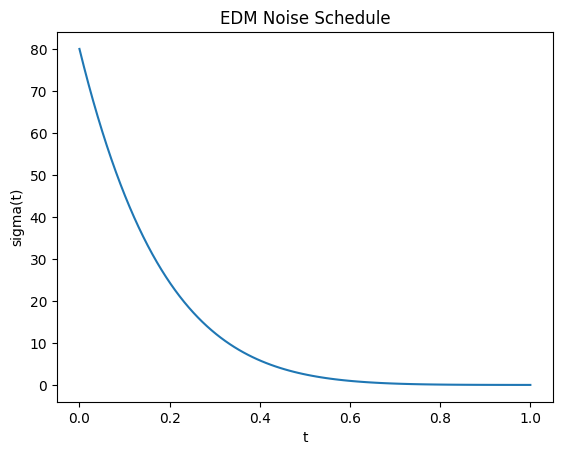

In [10]:
# EDM noise schedule, loss weighting, and sampling procedure

# EDM parameters from NVIDIA's reference
P_mean = -1.2  # Mean of log-normal distribution for sigma sampling
P_std = 1.2    # Std of log-normal distribution for sigma sampling
sigma_data = 0.5  # Data standard deviation
sigma_min = 0.002
sigma_max = 80
rho = 7

# EDM noise schedule (sampling)
def edm_sigma_schedule(t):
    return (sigma_max ** (1/rho) + t * (sigma_min ** (1/rho) - sigma_max ** (1/rho))) ** rho

# EDM loss weighting - CORRECTED according to NVIDIA's implementation
# weight = (σ² + σ_data²) / (σ × σ_data)²
def edm_loss_weight(sigma, sigma_data=sigma_data):
    return (sigma ** 2 + sigma_data ** 2) / (sigma * sigma_data) ** 2

# Example: plot the EDM noise schedule
ts = torch.linspace(0, 1, 100)
sigmas = edm_sigma_schedule(ts)
plt.plot(ts.numpy(), sigmas.numpy())
plt.xlabel('t')
plt.ylabel('sigma(t)')
plt.title('EDM Noise Schedule')
plt.show()

### 6b. EDM Sampling / Reconstruction

In [11]:
# EDM sampling procedure - Following NVIDIA's edm_sampler (Algorithm 2)
def edm_ancestral_sampling(model, num_steps=18, batch_size=8, img_shape=(1, 28, 28)):
    device = next(model.parameters()).device
    
    # Initialize noise
    x_next = torch.randn((batch_size,) + img_shape, device=device)
    
    # Time step schedule (matching NVIDIA's implementation)
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=device)
    t_steps = (sigma_max ** (1/rho) + step_indices / (num_steps - 1) * 
               (sigma_min ** (1/rho) - sigma_max ** (1/rho))) ** rho
    t_steps = torch.cat([t_steps, torch.zeros_like(t_steps[:1])])  # t_N = 0
    
    # Initialize with first noise level
    x_next = x_next * t_steps[0]
    
    # Main sampling loop (Heun's method)
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):
        x_cur = x_next
        
        # Preconditioning coefficients for current timestep
        sigma = t_cur.float()
        c_skip = sigma_data ** 2 / (sigma ** 2 + sigma_data ** 2)
        c_out = sigma * sigma_data / (sigma ** 2 + sigma_data ** 2).sqrt()
        c_in = 1 / (sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4
        
        # Euler step
        F_x = model(c_in * x_cur, c_noise.expand(batch_size))
        denoised = c_skip * x_cur + c_out * F_x
        d_cur = (x_cur - denoised) / t_cur
        x_next = x_cur + (t_next - t_cur) * d_cur
        
        # Apply 2nd order correction (Heun's method) - except for last step
        if i < num_steps - 1:
            # Preconditioning coefficients for next timestep
            sigma_next = t_next.float()
            c_skip_next = sigma_data ** 2 / (sigma_next ** 2 + sigma_data ** 2)
            c_out_next = sigma_next * sigma_data / (sigma_next ** 2 + sigma_data ** 2).sqrt()
            c_in_next = 1 / (sigma_data ** 2 + sigma_next ** 2).sqrt()
            c_noise_next = sigma_next.log() / 4
            
            F_x_next = model(c_in_next * x_next, c_noise_next.expand(batch_size))
            denoised_next = c_skip_next * x_next + c_out_next * F_x_next
            d_prime = (x_next - denoised_next) / t_next
            x_next = x_cur + (t_next - t_cur) * (0.5 * d_cur + 0.5 * d_prime)
    
    return x_next

In [12]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_edm_samples(model, batch_size=16, img_shape=(3,64,64), num_steps=36, title="EDM Samples", filename=None):
    """
    Generate and visualize EDM samples.
    """
    model.eval()
    with torch.no_grad():
        samples = edm_ancestral_sampling(model, num_steps=num_steps, batch_size=batch_size, img_shape=img_shape).cpu()
        samples = (samples + 1) / 2  # scale from [-1,1] to [0,1]
        samples = samples.clamp(0, 1)
    
    # Create a grid
    grid = vutils.make_grid(samples, nrow=int(batch_size**0.5))
    
    plt.figure(figsize=(6,6))
    plt.axis("off")
    plt.title(title)
    plt.imshow(grid.permute(1,2,0).numpy())
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.show()    
    model.train()


# 6c. EDM Training Loop 

In [13]:
model_edm = UNet128(use_attention=True).to(device)
optimizer_edm = optim.Adam(model_edm.parameters(), lr=2e-4)



In [14]:

edm_epochs = 999  # For demonstration; increase for better results
#model_edm = UNet28().to(device)
t0 = time.time()
next_display_time = t0
max_training_time = 30 * 60
display_interval = 30

#good_weights = "checkpoints/UNet128_2025-09-07_20-08-50_diverse_pokemon.pth"
#load_checkpoint(model_edm, optimizer_edm, good_weights)


In [15]:
# EDM training loop - CORRECTED with proper preconditioning coefficients
# Following NVIDIA's EDMPrecond implementation exactly

def train_a_batch(model_edm, optimizer_edm, batch):
 
        x = batch.to(device)
        
        # Log-normal sigma sampling (as in NVIDIA's implementation)
        rnd_normal = torch.randn([x.shape[0], 1, 1, 1], device=device)
        sigma = (rnd_normal * P_std + P_mean).exp()
        
        # Preconditioning coefficients (from NVIDIA's EDMPrecond)
        c_skip = sigma_data ** 2 / (sigma ** 2 + sigma_data ** 2)
        c_out = sigma * sigma_data / (sigma ** 2 + sigma_data ** 2).sqrt()
        c_in = 1 / (sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4
        
        # Add noise: y_noisy = x + σ·n where n ~ N(0,I)
        noise = torch.randn_like(x) * sigma
        y_noisy = x + noise
        
        # Model prediction: F_x = net(c_in * y_noisy, c_noise)
        c_noise_input = c_noise.view(x.shape[0])
        F_x = model_edm(c_in * y_noisy, c_noise_input)
        
        # Preconditioning: D_x = c_skip * y_noisy + c_out * F_x
        D_x = c_skip * y_noisy + c_out * F_x
        
        # Loss weight: λ(σ) = (σ² + σ_data²) / (σ·σ_data)²
        weight = edm_loss_weight(sigma.squeeze(), sigma_data).view(-1, 1, 1, 1)
        
        # Loss: weighted MSE between preconditioning output and clean image
        loss = (weight * (D_x - x) ** 2).mean()
        
        optimizer_edm.zero_grad()
        loss.backward()
        optimizer_edm.step()
        pbar.set_description(f"EDM Epoch {epoch+1} Loss: {loss.item():.4f}")


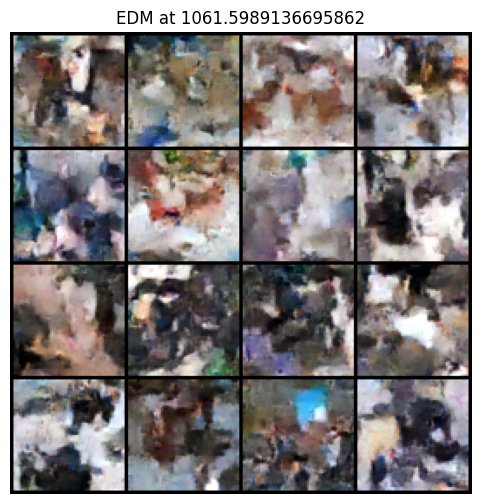

EDM Epoch 56 Loss: 0.1602:  73%|███████▎  | 46/63 [00:13<00:04,  3.49it/s]

In [ ]:
import IPython.display as ipd
display_interval = 60
next_display_time = time.time()
for epoch in range(99999999999):
    pbar = tqdm(train_loader)
    for x, _ in pbar:
        train_a_batch(model_edm,optimizer_edm,x)
        if time.time() > next_display_time:
            next_display_time += display_interval

            ipd.clear_output(wait=True)
            os.makedirs("outputs", exist_ok=True)

            timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            path = f"outputs/{timestamp}.png"
            show_edm_samples(model_edm,title=f"EDM at {time.time() - t0}", filename=path)

        

In [ ]:
save_checkpoint(model_edm, optimizer_edm, epoch, loss, tag="diverse_pokemon")

✅ Saved checkpoint: checkpoints/UNet128_2025-09-07_21-49-52_diverse_pokemon.pth


In [ ]:
good_weights = "checkpoints/UNet128_2025-09-07_20-08-50_diverse_pokemon.pth"
load_checkpoint(model_edm, optimizer_edm, good_weights)

RuntimeError: Error(s) in loading state_dict for UNet128:
	Missing key(s) in state_dict: "up0.weight", "up0.bias", "up_block0.conv1.weight", "up_block0.conv1.bias", "up_block0.conv2.weight", "up_block0.conv2.bias", "up_block0.time_mlp.weight", "up_block0.time_mlp.bias", "up_block0.skip.weight", "up_block0.skip.bias". 

In [ ]:
x.shape

torch.Size([71, 3, 64, 64])